# Importamos librerías - Creamos el dataframe de pericias

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

## Limpieza de texto

In [2]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador orizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [3]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [4]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

# Busqueda de titulos

In [5]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())
    return titulosMayusculasEncontrados
    
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)

## Eliminación de stopwords. Nueva limpieza

In [6]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text

# elimino stopwords y hago una última limpieza
titulosMayusculasStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasStop = remove_stops(str(titulosMayusculasStop))

# FASE DE ANALISIS

# N-Gramas

### Tokens

In [7]:
# FRECUENCIA DE TOKENS
# Creo dataframe de tokens de titulos en mayusculas
import pandas as pd
dfTitulosMayusculas = pd.DataFrame(titulosMayusculasStop,columns=['tokens'])
#Frecuencia de los tokens en los titulos.(15 mayores)
cantMay = dfTitulosMayusculas.value_counts()

In [8]:
#Creación de dataframe de token de titulos en mayúsculas
import pandas as pd
tokenFrec=[]
for k,v in cantMay.items():
    tokenFrec.append((k,v))

dfTokenMayusculas = pd.DataFrame(tokenFrec,columns=['Tokens','Frecuencia'])
# Porcentaje de aparicion de tokens
dfTokenMayusculas['Porcentaje'] = (dfTokenMayusculas['Frecuencia'] / dfTokenMayusculas['Frecuencia'].sum()) * 100
grafTokenMayus= dfTokenMayusculas.head(15)
grafTokenMayus

,Tokens,Frecuencia,Porcentaje
0,"(medico,)",829,6.289833
1,"(puntos,)",552,4.188164
2,"(pericia,)",529,4.013657
3,"(conclusiones,)",507,3.846737
4,"(petitorio,)",465,3.528073
5,"(legales,)",462,3.505311
6,"(antecedentes,)",457,3.467375
7,"(consideraciones,)",395,2.996965
8,"(legal,)",315,2.389985
9,"(autos,)",289,2.192716


### Gráfico de tokens

<AxesSubplot:ylabel='Tokens'>

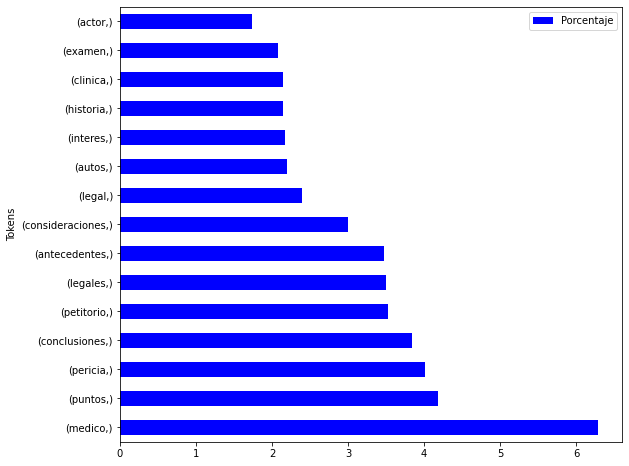

In [9]:
import matplotlib.pyplot as plt

colores = ['blue']
grafTokenMayus.plot(x= "Tokens", y="Porcentaje" ,kind = 'barh' , figsize=(9,8), color=colores)
#plt.savefig("tokenMayusculas.jpg")

### Tokens - Metodo 2

In [10]:
# METODO 2 - tokens DE TITULOS EN MAYUSCULAS

#tokens de títulos con mayúsculas.
tokenMay=(list(nltk.ngrams(titulosMayusculasStop,1)))
tokenMay

[('proemio',),
 ('antecedentes',),
 ('interes',),
 ('medico',),
 ('legal',),
 ('examen',),
 ('fisico',),
 ('actor',),
 ('consideraciones',),
 ('medico',),
 ('legales',),
 ('conclusiones',),
 ('incapacidad',),
 ('contestacion',),
 ('puntos',),
 ('pericia',),
 ('petitorio',),
 ('preambulo',),
 ('antecedentes',),
 ('interes',),
 ('medico',),
 ('presente',),
 ('autos',),
 ('examen',),
 ('perito',),
 ('oficio',),
 ('consideraciones',),
 ('medicas',),
 ('contestacion',),
 ('puntos',),
 ('periciales',),
 ('bibliografia',),
 ('conclusiones',),
 ('petitorio',),
 ('historia',),
 ('clinica',),
 ('puntos',),
 ('periciales',),
 ('estudios',),
 ('solicitados',),
 ('consideracionesconclusiones',),
 ('medico',),
 ('legales',),
 ('proemio',),
 ('evaluacion',),
 ('clinica',),
 ('incapacidad',),
 ('consideraciones',),
 ('medico',),
 ('legales',),
 ('conclusion',),
 ('bibliografia',),
 ('consultada',),
 ('petitorio',),
 ('ambos',),
 ('pies',),
 ('frenteoblicua',),
 ('datos',),
 ('personales',),
 ('moto',)

### Bigramas

#### Metodo 1

In [11]:
# Creo un archivo csv para utilizar en la generacion de n-gramas

#Se exporta el dataframe a un archivo csv
dfTitulosMayusculas.to_csv('titTokenEnMayusculas.csv', index=False, sep=';') 

In [12]:
# METODO 1 - BIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de bigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

bgsMayusculas = nltk.bigrams(token)

bgsMayusculaFdist = nltk.FreqDist(bgsMayusculas)
for k,v in bgsMayusculaFdist.items():
    print(f'{k} {v}')

('tokens', 'proemio') 1
('proemio', 'antecedentes') 24
('antecedentes', 'interes') 51
('interes', 'medico') 248
('medico', 'legal') 315
('legal', 'examen') 38
('examen', 'fisico') 69
('fisico', 'actor') 8
('actor', 'consideraciones') 51
('consideraciones', 'medico') 275
('medico', 'legales') 458
('legales', 'conclusiones') 95
('conclusiones', 'incapacidad') 6
('incapacidad', 'contestacion') 3
('contestacion', 'puntos') 179
('puntos', 'pericia') 485
('pericia', 'petitorio') 59
('petitorio', 'preambulo') 3
('preambulo', 'antecedentes') 10
('medico', 'presente') 1
('presente', 'autos') 1
('autos', 'examen') 31
('examen', 'perito') 46
('perito', 'oficio') 40
('oficio', 'consideraciones') 30
('consideraciones', 'medicas') 1
('medicas', 'contestacion') 1
('puntos', 'periciales') 53
('periciales', 'bibliografia') 1
('bibliografia', 'conclusiones') 15
('conclusiones', 'petitorio') 158
('petitorio', 'historia') 20
('historia', 'clinica') 278
('clinica', 'puntos') 8
('periciales', 'estudios') 3


In [13]:
# Mostrar los bigramas de mayor frecuencia
bgsMayusculaFdist.most_common(15)

[(('puntos', 'pericia'), 485),
 (('medico', 'legales'), 458),
 (('medico', 'legal'), 315),
 (('historia', 'clinica'), 278),
 (('consideraciones', 'medico'), 275),
 (('antecedentes', 'autos'), 250),
 (('interes', 'medico'), 248),
 (('autos', 'interes'), 196),
 (('pericia', 'conclusiones'), 188),
 (('contestacion', 'puntos'), 179),
 (('conclusiones', 'petitorio'), 158),
 (('hechos', 'historia'), 131),
 (('legal', 'hechos'), 101),
 (('conclusiones', 'medico'), 101),
 (('petitorio', 'antecedentes'), 96)]

In [14]:
# Creacion de dataframe de bigramas de titulos en mayusculas
import pandas as pd
bgsFrec=[]
for k,v in bgsMayusculaFdist.items():
    bgsFrec.append((k,v))

dfBgsMayusculas = pd.DataFrame(bgsFrec,columns=['bigrama','frecuencia'])
# Porcentaje de aparicion de tokens
dfBgsMayusculas['porcentaje'] = (dfBgsMayusculas['frecuencia'] / dfBgsMayusculas['frecuencia'].sum()) * 100
dfBgsMayusculas


,bigrama,frecuencia,porcentaje
0,"(tokens, proemio)",1,0.007587
1,"(proemio, antecedentes)",24,0.182094
2,"(antecedentes, interes)",51,0.386950
3,"(interes, medico)",248,1.881639
4,"(medico, legal)",315,2.389985
...,...,...,...
3297,"(cnat, datos)",1,0.007587
3298,"(psicologico, antecedentes)",1,0.007587
3299,"(petitorio, nestor)",1,0.007587
3300,"(nestor, antecedentes)",1,0.007587


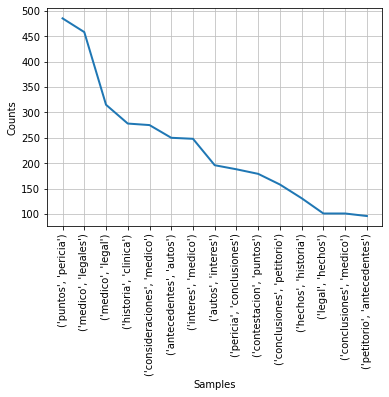

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
bgsMayusculaFdist.plot(15) #Ver las 15 colocaciones más frecuentes

### Bigramas
#### Metodo 2

In [16]:
# METODO 2 - BIGRAMAS DE TITULOS EN MAYUSCULAS

#bigrama de títulos con mayúsculas.
bigramaMay=(list(nltk.ngrams(titulosMayusculasStop,2)))

In [17]:
#Cantidad de veces que se repiten los bigramas en los titulos con mayúsculas.
import pandas as pd
FrecuenciaBigMay = pd.DataFrame(bigramaMay,columns=['TOKEN1','TOKEN2'])
cantBigMay = FrecuenciaBigMay.value_counts()
print(cantBigMay)

TOKEN1           TOKEN2      
puntos           pericia         485
medico           legales         458
                 legal           315
historia         clinica         278
consideraciones  medico          275
                                ... 
examenes         fisicos           1
examinada        modalidad         1
examinado        actitud           1
                 antecedentes      1
zuedn            tiende            1
Length: 3301, dtype: int64


In [18]:
#Creación de dataframe de bigramas de titulos en mayúsculas
import pandas as pd
bigFrec=[]
for k,v in cantBigMay.items():
    bigFrec.append((k,v))

dfBigMayusculas = pd.DataFrame(bigFrec,columns=['Bigrama','Frecuencia'])
# Porcentaje de aparicion de tokens
dfBigMayusculas['Porcentaje'] = (dfBigMayusculas['Frecuencia'] / dfBigMayusculas['Frecuencia'].sum()) * 100
grafBigMayus= dfBigMayusculas.head(15)
grafBigMayus

,Bigrama,Frecuencia,Porcentaje
0,"(puntos, pericia)",485,3.680097
1,"(medico, legales)",458,3.475226
2,"(medico, legal)",315,2.390166
3,"(historia, clinica)",278,2.109416
4,"(consideraciones, medico)",275,2.086653
5,"(antecedentes, autos)",250,1.896957
6,"(interes, medico)",248,1.881782
7,"(autos, interes)",196,1.487215
8,"(pericia, conclusiones)",188,1.426512
9,"(contestacion, puntos)",179,1.358221


<AxesSubplot:ylabel='Bigrama'>

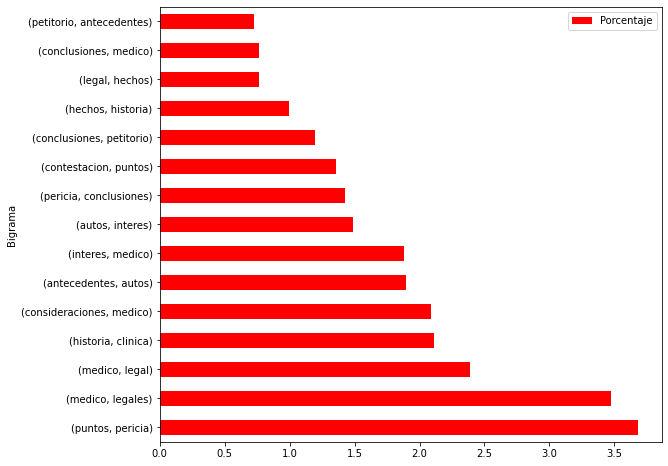

In [19]:
# Gráfico de barras - representación de bigramas
colores = ['red']
grafBigMayus.plot(x= "Bigrama", y="Porcentaje" ,kind = 'barh', figsize=(9,8), color=colores)
#plt.savefig("bigramaMayusculas.jpg")

### Trigrama
#### Metodo 1

In [20]:
# METODO 1 - TRIGRAMAS DE TITULOS EN MAYUSCULAS

#trigrama de títulos con mayúsculas.
trigramaMay=(list(nltk.ngrams(titulosMayusculasStop,3)))
trigramaMay

[('proemio', 'antecedentes', 'interes'),
 ('antecedentes', 'interes', 'medico'),
 ('interes', 'medico', 'legal'),
 ('medico', 'legal', 'examen'),
 ('legal', 'examen', 'fisico'),
 ('examen', 'fisico', 'actor'),
 ('fisico', 'actor', 'consideraciones'),
 ('actor', 'consideraciones', 'medico'),
 ('consideraciones', 'medico', 'legales'),
 ('medico', 'legales', 'conclusiones'),
 ('legales', 'conclusiones', 'incapacidad'),
 ('conclusiones', 'incapacidad', 'contestacion'),
 ('incapacidad', 'contestacion', 'puntos'),
 ('contestacion', 'puntos', 'pericia'),
 ('puntos', 'pericia', 'petitorio'),
 ('pericia', 'petitorio', 'preambulo'),
 ('petitorio', 'preambulo', 'antecedentes'),
 ('preambulo', 'antecedentes', 'interes'),
 ('antecedentes', 'interes', 'medico'),
 ('interes', 'medico', 'presente'),
 ('medico', 'presente', 'autos'),
 ('presente', 'autos', 'examen'),
 ('autos', 'examen', 'perito'),
 ('examen', 'perito', 'oficio'),
 ('perito', 'oficio', 'consideraciones'),
 ('oficio', 'consideraciones',

In [21]:
# METODO 2 - TRIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de trigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

trigsMayuscula = nltk.trigrams(token)

trigsMayusculaFdist = nltk.FreqDist(trigsMayuscula)
for k,v in trigsMayusculaFdist.items():
    print(f'{k} {v}')

('tokens', 'proemio', 'antecedentes') 1
('proemio', 'antecedentes', 'interes') 13
('antecedentes', 'interes', 'medico') 46
('interes', 'medico', 'legal') 222
('medico', 'legal', 'examen') 38
('legal', 'examen', 'fisico') 5
('examen', 'fisico', 'actor') 8
('fisico', 'actor', 'consideraciones') 4
('actor', 'consideraciones', 'medico') 45
('consideraciones', 'medico', 'legales') 270
('medico', 'legales', 'conclusiones') 95
('legales', 'conclusiones', 'incapacidad') 3
('conclusiones', 'incapacidad', 'contestacion') 3
('incapacidad', 'contestacion', 'puntos') 3
('contestacion', 'puntos', 'pericia') 169
('puntos', 'pericia', 'petitorio') 55
('pericia', 'petitorio', 'preambulo') 2
('petitorio', 'preambulo', 'antecedentes') 2
('preambulo', 'antecedentes', 'interes') 2
('interes', 'medico', 'presente') 1
('medico', 'presente', 'autos') 1
('presente', 'autos', 'examen') 1
('autos', 'examen', 'perito') 1
('examen', 'perito', 'oficio') 40
('perito', 'oficio', 'consideraciones') 25
('oficio', 'cons

In [22]:
# Mostrar los trigramas de mayor frecuencia
trigsMayusculaFdist.most_common(15)


[(('consideraciones', 'medico', 'legales'), 270),
 (('interes', 'medico', 'legal'), 222),
 (('antecedentes', 'autos', 'interes'), 186),
 (('puntos', 'pericia', 'conclusiones'), 180),
 (('autos', 'interes', 'medico'), 177),
 (('contestacion', 'puntos', 'pericia'), 169),
 (('hechos', 'historia', 'clinica'), 131),
 (('pericia', 'conclusiones', 'petitorio'), 118),
 (('medico', 'legal', 'hechos'), 101),
 (('legal', 'hechos', 'historia'), 100),
 (('conclusiones', 'medico', 'legales'), 100),
 (('medico', 'legales', 'conclusiones'), 95),
 (('historia', 'clinica', 'actor'), 91),
 (('historia', 'clinica', 'contestacion'), 90),
 (('clinica', 'contestacion', 'puntos'), 90)]

In [23]:
# Creacion de dataframe de trigramas de titulos en mayusculas
import pandas as pd
trigsFrec=[]
for k,v in trigsMayusculaFdist.items():
    trigsFrec.append((k,v))

dfTrigsMayusculas = pd.DataFrame(trigsFrec,columns=['trigrama','frecuencia'])
dfTrigsMayusculas

,trigrama,frecuencia
0,"(tokens, proemio, antecedentes)",1
1,"(proemio, antecedentes, interes)",13
2,"(antecedentes, interes, medico)",46
3,"(interes, medico, legal)",222
4,"(medico, legal, examen)",38
...,...,...
4783,"(incapacidad, petitorio, nestor)",1
4784,"(petitorio, nestor, antecedentes)",1
4785,"(nestor, antecedentes, autos)",1
4786,"(petitorio, clgsa, historia)",1


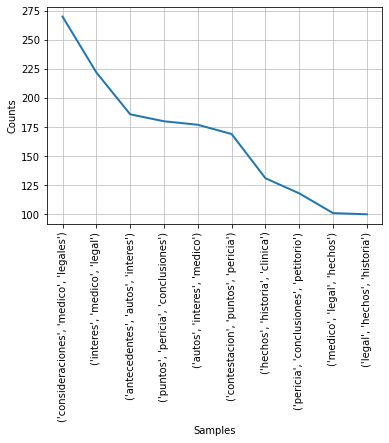

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
trigsMayusculaFdist.plot(10)

### Trigramas
#### Metodo 2

In [25]:
#Cantidad de veces que se repiten los trigramas en los titulos con mayúsculas.
import pandas as pd
FrecuenciaTrigMay = pd.DataFrame(trigramaMay,columns=['TOKEN1','TOKEN2','TOKEN3'])
cantTrigMay = FrecuenciaTrigMay.value_counts()
print(cantTrigMay)

TOKEN1           TOKEN2           TOKEN3      
consideraciones  medico           legales         270
interes          medico           legal           222
antecedentes     autos            interes         186
puntos           pericia          conclusiones    180
autos            interes          medico          177
                                                 ... 
estudios         consideraciones  medico            1
                                  puntos            1
                 realizados       puntos            1
                 solicitadosa     puntos            1
zuedn            tiende           petitorio         1
Length: 4787, dtype: int64


In [26]:
#Creación de dataframe de bigramas de titulos en mayúsculas
import pandas as pd
trigFrec=[]
for k,v in cantTrigMay.items():
    trigFrec.append((k,v))

dfTrigMayusculas = pd.DataFrame(trigFrec,columns=['Trigrama','Frecuencia'])
# Porcentaje de aparicion de tokens
dfTrigMayusculas['Porcentaje'] = (dfTrigMayusculas['Frecuencia'] / dfTrigMayusculas['Frecuencia'].sum()) * 100
grafTrigMayus= dfTrigMayusculas.head(15)
grafTrigMayus

,Trigrama,Frecuencia,Porcentaje
0,"(consideraciones, medico, legales)",270,2.048869
1,"(interes, medico, legal)",222,1.684626
2,"(antecedentes, autos, interes)",186,1.411443
3,"(puntos, pericia, conclusiones)",180,1.365913
4,"(autos, interes, medico)",177,1.343148
5,"(contestacion, puntos, pericia)",169,1.282440
6,"(hechos, historia, clinica)",131,0.994081
7,"(pericia, conclusiones, petitorio)",118,0.895432
8,"(medico, legal, hechos)",101,0.766429
9,"(legal, hechos, historia)",100,0.758840


<AxesSubplot:ylabel='Trigrama'>

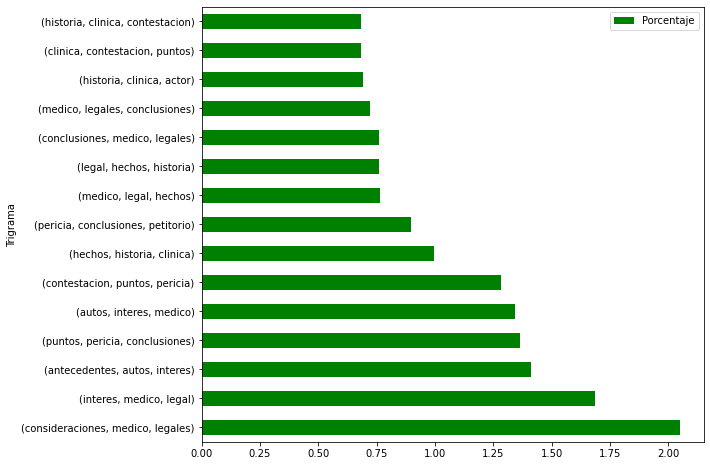

In [27]:
# Gráfico de barras - representación de trigramas
colores = ['green']
grafTrigMayus.plot(x= "Trigrama", y="Porcentaje" ,kind = 'barh', figsize=(9,8), color=colores)
#plt.savefig("trigramaMayusculas.jpg")

### 5-GRAMAS

In [28]:
#5-grama de títulos con mayúsculas.
cincogramaMay=(list(nltk.ngrams(titulosMayusculasStop,5)))
cincogramaMay

[('proemio', 'antecedentes', 'interes', 'medico', 'legal'),
 ('antecedentes', 'interes', 'medico', 'legal', 'examen'),
 ('interes', 'medico', 'legal', 'examen', 'fisico'),
 ('medico', 'legal', 'examen', 'fisico', 'actor'),
 ('legal', 'examen', 'fisico', 'actor', 'consideraciones'),
 ('examen', 'fisico', 'actor', 'consideraciones', 'medico'),
 ('fisico', 'actor', 'consideraciones', 'medico', 'legales'),
 ('actor', 'consideraciones', 'medico', 'legales', 'conclusiones'),
 ('consideraciones', 'medico', 'legales', 'conclusiones', 'incapacidad'),
 ('medico', 'legales', 'conclusiones', 'incapacidad', 'contestacion'),
 ('legales', 'conclusiones', 'incapacidad', 'contestacion', 'puntos'),
 ('conclusiones', 'incapacidad', 'contestacion', 'puntos', 'pericia'),
 ('incapacidad', 'contestacion', 'puntos', 'pericia', 'petitorio'),
 ('contestacion', 'puntos', 'pericia', 'petitorio', 'preambulo'),
 ('puntos', 'pericia', 'petitorio', 'preambulo', 'antecedentes'),
 ('pericia', 'petitorio', 'preambulo', 

In [38]:
#Cantidad de veces que se repiten los 5-gramas en los titulos con mayúsculas.
import pandas as pd
Frecuencia5May = pd.DataFrame(cincogramaMay,columns=['TOKEN1','TOKEN2','TOKEN3','TOKEN4','TOKEN5'])
cant5May = Frecuencia5May.value_counts(ascending=False)
print(cant5May)

TOKEN1        TOKEN2           TOKEN3      TOKEN4        TOKEN5              
antecedentes  autos            interes     medico        legal                   153
contestacion  puntos           pericia     conclusiones  petitorio               102
medico        legal            hechos      historia      clinica                 100
interes       medico           legal       hechos        historia                100
autos         interes          medico      legal         hechos                  100
                                                                                ... 
evaluacion    peritado         semiologia  regiones      conclusiones              1
              medico           legal       contestacion  puntos                    1
              datos            personales  entrestado    presentaciondiscurso      1
              contestacionlos  puntos      pericia       solicitados               1
zuedn         tiende           petitorio   utilizado     conclusiones   

In [39]:
#Creación de dataframe de 5-gramas de titulos en mayúsculas
import pandas as pd
cincoGramaFrec=[]
for k,v in cant5May.items():
    cincoGramaFrec.append((k,v))

df5Mayusculas = pd.DataFrame(cincoGramaFrec,columns=['5-grama','Frecuencia'])
# Porcentaje de aparicion de tokens
df5Mayusculas['Porcentaje'] = (df5Mayusculas['Frecuencia'] / df5Mayusculas['Frecuencia'].sum()) * 100
graf5Mayus= df5Mayusculas.head(15)
graf5Mayus

,5-grama,Frecuencia,Porcentaje
0,"(antecedentes, autos, interes, medico, legal)",153,1.161202
1,"(contestacion, puntos, pericia, conclusiones, ...",102,0.774135
2,"(medico, legal, hechos, historia, clinica)",100,0.758956
3,"(interes, medico, legal, hechos, historia)",100,0.758956
4,"(autos, interes, medico, legal, hechos)",100,0.758956
5,"(historia, clinica, contestacion, puntos, peri...",90,0.683060
6,"(clinica, contestacion, puntos, pericia, concl...",87,0.660291
7,"(legal, hechos, historia, clinica, contestacion)",83,0.629933
8,"(hechos, historia, clinica, contestacion, puntos)",83,0.629933
9,"(petitorio, antecedentes, autos, interes, medico)",52,0.394657


<AxesSubplot:ylabel='5-grama'>

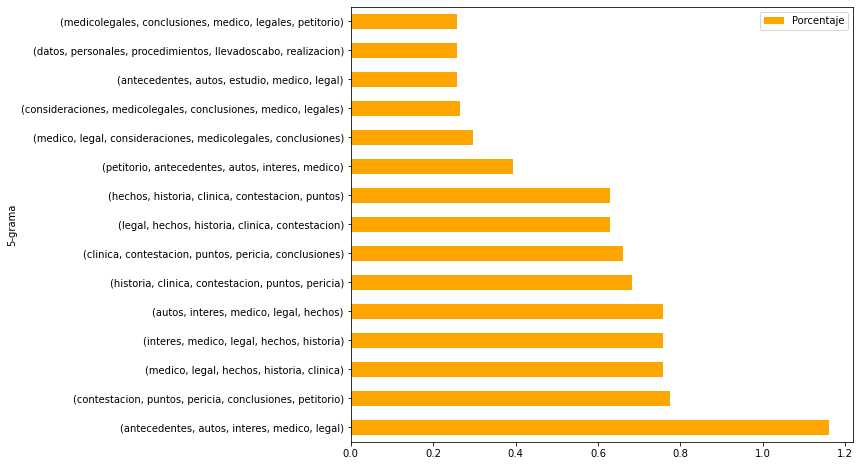

In [41]:
# Gráfico de barras - representación de trigramas
colores = ['orange']

graf5Mayus.plot(x= "5-grama", y="Porcentaje" ,kind = 'barh', figsize=(9,8), color=colores)
#plt.savefig("cincoGramaMayusculas.jpg")

# CREACION DE LA NUBE DE PALABRAS

In [32]:
# elimino los stopword de titulos en mayusculas para la nube de palabras
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text
titulosMayusculasSinStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasSinStop = remove_stops(str(titulosMayusculasSinStop))

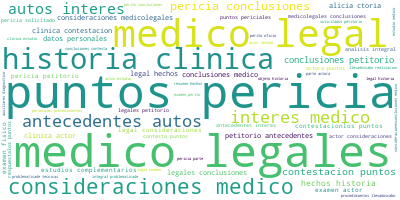

In [33]:
# Creacion de la nube de palabras de tokens - bigramas
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(titulosMayusculasSinStop))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
titulosMayusculasSinStop

In [35]:

titulosMayusculasSinStop.count("consideraciones")

395

In [36]:
titulosMayusculas.count('CONSIDERACIONES')

0

In [ ]:
# cuenta-elementos-de-lista-1.py

frecuenciaPalab = []
frecuenciaPalab = [titulosMayusculasSinStop.count(w) for w in titulosMayusculasSinStop] # lista por comprension, como for pero mejor

#print("Lista\n" + str(titulosMayusculasSinStop) + "\n")
#print("Frecuencias\n" + str(frecuenciaPalab) + "\n")
print("Pares\n" + str(list(zip(titulosMayusculasSinStop, frecuenciaPalab))))

In [ ]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()